# Preprocessing

In [220]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../../../data/EDA.csv')

## Clarifying important predictor values (x) for the target value (y).

In [29]:
# dropping the target (y) values from x and specific origin
features = df.drop(['ref', 'company_manufacturer', 'company_location', 'review_date', 'country_of_bean_origin', 'specific_bean_origin_or_bar_name', 'cocoa_percent','ingredients', 'most_memorable_characteristics', 'rating', 'rating_class'], axis =1)

X = features
y = df.rating_class


### Splitting the data into three subsets of training and validation data for the future models.
    Two train test splits create three subsets of the original dataset which allows for the training data to not be bled into the test data - this reduced model's bias towards the pre-existing testing data, thus assuring maximum performance on future test sets to which the model has never been exposed. 

In [30]:
#performing train test split for test set (subsets 1/3)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=42)


#performing a train test split for train and validation set (subsets - 3/3)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=42) 

In [31]:
#checking to ensure the shape of the columns and rows are still the same for the X and y values after the train test split.
X_tr.shape, y_tr.shape

((1896, 8), (1896,))

# Replacing any existing missing values

In [32]:
#ingredients have 88 rows that have no imputs.
X_val.isna().sum()

memorable_characteristics_list    0
company_loc_bins                  0
bean_origin_bins                  0
weighted_specific_origin_bins     0
ingredient_list                   0
review_date_bin                   0
cocoa_bucket                      0
comp_manufact_bin                 0
dtype: int64

In [33]:
# the empty value replacement will be done using the most frequent fill strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X.columns)

X_val_imputed = pd.DataFrame(imputer.fit_transform(X_val),columns = X.columns)

In [34]:
#ensuring that the missing values from ingredients are now filled in with the most frequent occuring value

X_val_imputed.isna().sum()

memorable_characteristics_list    0
company_loc_bins                  0
bean_origin_bins                  0
weighted_specific_origin_bins     0
ingredient_list                   0
review_date_bin                   0
cocoa_bucket                      0
comp_manufact_bin                 0
dtype: int64

### Separating groups into numeric and catagorical data types 

In [35]:
#taking a look at the groups data types to ensure that they are separated correctly
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 1258 to 1818
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   memorable_characteristics_list  1611 non-null   object
 1   company_loc_bins                1611 non-null   int64 
 2   bean_origin_bins                1611 non-null   int64 
 3   weighted_specific_origin_bins   1611 non-null   int64 
 4   ingredient_list                 1611 non-null   object
 5   review_date_bin                 1611 non-null   object
 6   cocoa_bucket                    1611 non-null   object
 7   comp_manufact_bin               1611 non-null   object
dtypes: int64(3), object(5)
memory usage: 113.3+ KB


### One Hot Encode Categorical Features 

In [36]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [37]:
# fit on training categorical data
ohe.fit(X_train)
X_train_encoded = ohe.transform(X_train)
X_val_encoded = ohe.transform(X_val)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_val_encoded_df= pd.DataFrame(X_val_encoded, columns=ohe.get_feature_names())

In [38]:
#put the encoded and origin splitting together
X_train_df = pd.concat([X_train, X_train_encoded_df], axis=1)
X_val_df = pd.concat([X_val, X_val_encoded_df], axis=1)

In [39]:
#dropping the bins 
X_train_df = X_train_df.drop(['review_date_bin','bean_origin_bins','comp_manufact_bin','ingredient_list','cocoa_bucket'], axis=1)
X_val_df = X_val_df.drop(['review_date_bin','bean_origin_bins','comp_manufact_bin','ingredient_list','cocoa_bucket'], axis=1)

# Modeling:

##  Model 1: Logistic Regression

In [177]:
# Instantiating a Logistic Regression model
logreg1 = LogisticRegression(class_weight={0: 0.77, 1: 0.23},
                        solver='newton-cg')

In [178]:
def modeling_function(model, X_train, y_train, X_val, y_val):

    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Print accuracy score
    print('Training score: ', f1_score(y_train, train_preds))
    print('Validation score: ', f1_score(y_val, val_preds))

    # return fitted model
    return model

In [179]:
# call modeling function
logreg_1 = modeling_function(logreg, X_train_encoded_df, y_train, X_val_encoded_df, y_val)


Training score:  0.9025715320536037
Validation score:  0.884


>this was a great starting poing, but the model seems to be overfit as the validation score is visible lower than the training score.

### creating a confusion matrix from the logistical regression model

In [ ]:
plot_confusion_matrix(logreg, X_train_encoded_df, y_train)

In [ ]:
#there is a visible imbalance within the data set which could be improved by using SMOTE
y_train.value_counts()

## Using smote SMOTE on the training set to balance the training dataset

In [ ]:
sm = SMOTE(random_state=42)

In [ ]:
#fitting the training set to smote
X_train_res, y_train_res = sm.fit_resample(X_train_encoded_df, y_train)

y_train_res.value_counts()

> the training set is now balanced

## Grid Search CV - Model 1: Logistical Regression

In [ ]:
# Looking into class weight.
# The model will predict positive - 
y.value_counts(normalize=True)

In [187]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'logisticregression', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [214]:
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(SMOTE(random_state=42), LogisticRegression())

param_grid = {  
                'logisticregression__C':[.5,.7,.8,.9,1.0],
                'logisticregression__class_weight':[ { 0:.77, 1:.23}, None, "balanced" ],
              'logisticregression__penalty': ['l1', 'l2'], 
                'logisticregression__solver': [ 'lbfgs', 'liblinear', 'sag', 'saga'],
                'logisticregression__max_iter':[100, 1000, 10000]}

gs1 = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='f1')



gs1.fit(X_train_encoded_df,  y_train)

#returning the best hyperparameters from the search grid
best_params = gs1.best_params_
best_params


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penal

{'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [221]:
est = gs1.best_estimator_

In [218]:
modeling_function(est, X_train_res, y_train_res, X_val_encoded_df, y_val)



Training score:  0.9277256022866477
Validation score:  0.8682505399568035


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

> The model with parameters has a positive outcome; however, the training data is still overfit

In [ ]:
plot_confusion_matrix(est, X_val_encoded_df, )

##  Model 2: Lostistical Regression

In [135]:
logreg2 = LogisticRegression(
                             C=1,
                             max_iter=1000,
                             penalty='l2',
                             solver= 'newton-cg')

In [136]:
logreg_2 = modeling_function(logreg2, X_train_res, y_train_res, X_val_encoded_df, y_val)

Training score:  0.9580983078162771
Validation score:  0.8329519450800915


> score with balanced dataset ended up returning a worse outcome that model 1. The model is very overfit.

## Model 3: Decision Tree Classifier

In [111]:
dt1 = DecisionTreeClassifier(random_state=42, max_depth=2)

In [112]:
dt1 = modeling_function(dt, X_train_res, y_train_res, X_val_encoded_df, y_val)

Training score:  0.6636670416197976
Validation score:  0.7902439024390244


### creating a confusion matrix for the decision tree classifier 

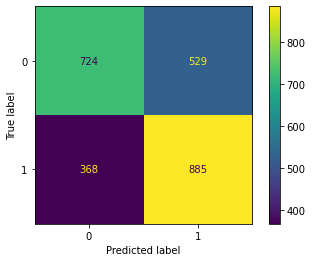

In [104]:
#inspecting a confusion plot matrcix for the decision tree training set 
plot_confusion_matrix(dt, X_train_res, y_train_res)

## Grid Search CV - Model 3: Decision Tree Classifier

In [141]:
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth' : [2,3,4,5,6,7,8,9,10],
              'max_leaf_nodes': [2,3,4,5,6,7,8,9,10,11,12,13,14]}

dt1_gs = GridSearchCV(estimator=dt1, param_grid=param_grid, scoring='f1')
dt1_gs.fit(X_train_res,  y_train_res)
best_params = dt3_gs.best_params_
best_params

{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 12}

{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 12}

## Model 4: Decision Tree Classifier with  Hyperparameters

In [171]:
dt2 = modeling_function(dt1_gs, X_train_res, y_train_res, X_val_encoded_df, y_val)


Training score:  0.6982997232107552
Validation score:  0.7468671679197997


> Worse outcome with decision tree and tuned hyperparameters; however, the outcome was less bias to the training set than before.

## Model 5: Random Forest Classifier

In [145]:
rf1 = RandomForestClassifier(random_state=42)

In [146]:
rf1 = modeling_function(rf, X_train_res, y_train_res, X_val_encoded_df, y_val)

Training score:  1.0
Validation score:  0.8848484848484849


> Although it is still overfit, the random forest classifier seems to have an improved outcome in relation to the random tree classifier. It would be interesting to see the outcome with tuned hyperparameters


### Grid Search CV - Model 5: Random Forest Classifier

In [167]:
#with class weight
param_grid = {'criterion' : ['gini', 'entropy'], 'max_depth' : [2,3,4,5,6,7,8,9,10], 'max_leaf_nodes': [2,3,4,5,6,7,8,9,10,11,12,13,14], 'class_weight' : [{0:0.78 , 1:0.22}]}

rf1_gs = GridSearchCV(estimator=rf1, param_grid=param_grid, scoring='f1', n_jobs=-1)
rf1_gs.fit(X_train_encoded_df,  y_train)
m5_params = rfc3_gs.best_params_
m5_params

{'class_weight': {0: 0.78, 1: 0.22},
 'criterion': 'entropy',
 'max_depth': 7,
 'max_leaf_nodes': 14}

In [168]:
m5_estimator = rfc3_gs.best_estimator_

## Model 6: Random Forest Classifier with Hyperparameters

In [169]:
rf2 = modeling_function(rf1_gs, X_train_encoded_df, y_train, X_val_encoded_df, y_val)



Training score:  0.8343711083437111
Validation score:  0.7980769230769231


## Model 7: XGL Boost

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_res, y_train_res)

# Predict on training and test sets
training_preds = clf.predict(X_train_res)
test_preds = clf.predict(X_val_encoded_df)

# Accuracy of training and test sets
training_score = f1_score(y_train_res, training_preds)
test_score = f1_score(y_val, test_preds)

print('Training Score: {:.4}%'.format(training_score * 100))
print('Validation Score: {:.4}%'.format(test_score * 100))

In [ ]:
X_train_res = X_train_res.rename({'x1_(41.999, 70.0]':'x1_lower', 'x1_(70.0, 100.0]':'x1_higher'}, axis='columns')



In [ ]:
X_val_encoded_df = X_val_encoded_df.rename({'x1_(41.999, 70.0]':'x1_lower', 'x1_(70.0, 100.0]':'x1_higher'}, axis='columns')

